## 初期条件

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import pickle
import random
import functools

from visualize import visualization
myvs = visualization()
from select_datasets import Select_datasets as my_SD
myds = my_SD("/data7/ALL/db/ns/8k")
from sklearn.preprocessing import StandardScaler


#sample_data

path="/data6/ALL/db/ns/8k"
npz_files = glob.glob(path+"/**.npz")

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.get_cmap("Set1").colors)

d = np.load(npz_files[3])

D_df = pd.DataFrame(d["arr_0"]).T

# Constant

f_s = 12.5*10**3
th_s = 2
N = 4096
pixel_number=36

f_range = f_s/th_s
f_resolution = f_range/N

min_freq = 0.1
max_freq = 15

start = math.ceil(min_freq/f_resolution)-1
stop = math.ceil(max_freq/f_resolution)-1

x = np.arange(start+1,stop+1)*f_resolution
D_df_limfreq = D_df.iloc[:,start:stop]

## データ取得

In [3]:
# low freq

Imamura_list_data6 = glob.glob("/home/kashiwazaki/Bthesis/edata_/edata/**.npz")
df_imamura_abnormal_data = myds.concat_npz(Imamura_list_data6)
df_ImamuraAbnormal_pre = df_imamura_abnormal_data.iloc[:,start:stop]
df_ImamuraAbnormal_pre = myds.delete_0_gyou(df_ImamuraAbnormal_pre)

Imamura_list_data7 = []
for d in Imamura_list_data6:
    Imamura_list_data7.append("/data7/ALL/db/ns/8k/"+d.split("/")[-1]) 

df_ImamuraAbnormal_pre

/usr/local/conda/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0           1           2           3           4           5  \
0     2659.198621  393.325415  454.642862  250.441237  233.678012  272.528985   
1     2431.311344  354.902017  409.156847  229.841866  235.572640  265.035149   
2     2638.853545  400.680499  440.336101  348.278691  331.823008  337.998418   
3     2540.309984  397.117338  415.029425  247.074044  286.974103  302.569158   
4     2566.477486  398.898264  391.118480  300.232387  293.232228  332.539906   
...           ...         ...         ...         ...         ...         ...   
1351   355.217192  156.399793  166.019671  198.384994  225.776400  252.953558   
1352   371.715936  153.365039  150.408107  196.258235  213.059565  241.756654   
1353   339.493341  172.065658  159.476038  184.333826  192.349654  251.711225   
1354   291.075822  151.676753  174.019234  180.799240  184.088673  226.376313   
1355   357.759634  151.694597  152.637684  192.016122  192.844064  259.057854   

               6           7           8  
0     293.880414  342.573205  425.434550  
1     280.273539  287.032880  344.686973  
2     346.077760  344.394115  431.331192  
3     296.226159  309.196664  351.411071  
4     371.549184  338.718384  384.407480  
...          ...         ...         ...  
1351  247.176909  375.444268  514.476939  
1352  267.752230  318.121015  489.978479  
1353  275.325876  346.019341  485.400973  
1354  292.429978  317.118807  460.521005  
1355  273.008020  319.235240  495.596096  

[1356 rows x 9 columns]

In [5]:
df_ImamuraAbnormal_train,df_ImamuraAbnormal_test = myds.train_test_dataframe(df_ImamuraAbnormal_pre,test_frac=0.5)

In [6]:
len(df_ImamuraAbnormal_train)

678

In [7]:
# normal データ

npz_files = glob.glob("/data7/ALL/db/ns/8k/**.npz")
for d in Imamura_list_data7:
    if d in npz_files:
        npz_files.remove(d)
    
df_data7 = myds.concat_npz(npz_files)
df_data7_pre = df_data7[(df_data7 < 10**10).all(axis=1)]
df_data7_pre = df_data7_pre.iloc[:,start:stop]
df_data7_pre = myds.delete_0_gyou(df_data7_pre)

In [8]:
List_test_Lowindex = List_test_Lowindex = [960,418,417,845,523,127,342,750,151,963,896,495,466,218,34,519,466,936,714,21,34,559,667,601]

In [12]:
# low -2 mtq -1

df_train,df_test = myds.train_test_dataframe(df_data=df_data7_pre,test_frac=0.01)

#教師 normal　ピーク1500以下
df_train = df_train[(df_train<1500).all(axis=1)]
print(len(df_train))
#教師 normal avarage 化

per=40
lim = len(df_train)//per*per

df_train = df_train.sample(frac=1)
df_train = df_train.to_numpy()[:lim].reshape([int(lim/per),per,len(df_train.to_numpy()[0])])
df_train = pd.DataFrame(myvs.avarange(df_train))
df_train_ = df_train

#テストノーマル作成

df_test_ = df_test[~df_test.index.isin(df_test.loc[List_test_Lowindex].index)]
df_test_ = df_test_[(df_test_<700).all(axis=1)]

#教師作成
y_train_true = np.concatenate([
np.ones(len(df_train)),
np.ones(len(df_ImamuraAbnormal_train))*-2])

#テスト正解作成
y_test_true = np.concatenate([
np.ones(len(df_test_)),
np.ones(len(df_ImamuraAbnormal_test))*-2])

#学習データ
print(f"train_normallim:{len(df_train)},lowfreqlim:{len(df_train)+len(df_ImamuraAbnormal_train)}")
df_train = pd.concat([df_train,df_ImamuraAbnormal_train])
df_train.index = range(len(df_train))

#テストデータ
print(f"test_normallim:{len(df_test_)},lowfreqlim:{len(df_test_)+len(df_ImamuraAbnormal_test)}")
df_test = pd.concat([df_test_,df_ImamuraAbnormal_test])
df_test.index = range(len(df_test))

df_train_pre = df_train

df_test

101879
train_normallim:2546,lowfreqlim:3224
test_normallim:987,lowfreqlim:1665


0            1            2            3            4  \
0      177.645794   376.756648   211.168020   192.792260   232.578517   
1      148.740738   150.464402   163.063919   191.429784   206.294692   
2      385.297973   137.329077   137.027833   169.794243   265.565935   
3      515.833407   230.810678   163.613421   187.003327   255.261245   
4      125.080703    92.948290   159.533422   196.579004   191.402014   
...           ...          ...          ...          ...          ...   
1660   362.708991   621.966858  1396.998057   374.549207   289.716703   
1661  3147.473787  1585.340175  1340.545573  1430.948491  1303.089528   
1662  3208.956873  2161.943672  2920.847104  3976.552563  4019.850302   
1663   283.191189   350.633101  1631.245818   432.111701   288.347313   
1664   360.426802   503.021624   414.725398   523.103324   654.387147   

                5            6            7            8  
0      285.036802   297.044322   547.465903   397.960650  
1      226.897426   272.352024   301.800941   354.816608  
2      205.150935   276.779341   241.370220   293.060071  
3      256.652317   305.182217   211.609182   327.717840  
4      212.626197   226.729456   313.370967   280.203435  
...           ...          ...          ...          ...  
1660   288.895725   573.118652   325.007840   353.971366  
1661  1521.616229  1413.585047  1699.933378  1791.307483  
1662  3785.661623  4040.741129  4056.972708  4225.166046  
1663   333.080988   553.216880   355.073430   355.997260  
1664   874.062817  1393.979500  5922.502231  2681.439522  

[1665 rows x 9 columns]

/usr/local/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == "":


Text(0, 0.5, 'power')

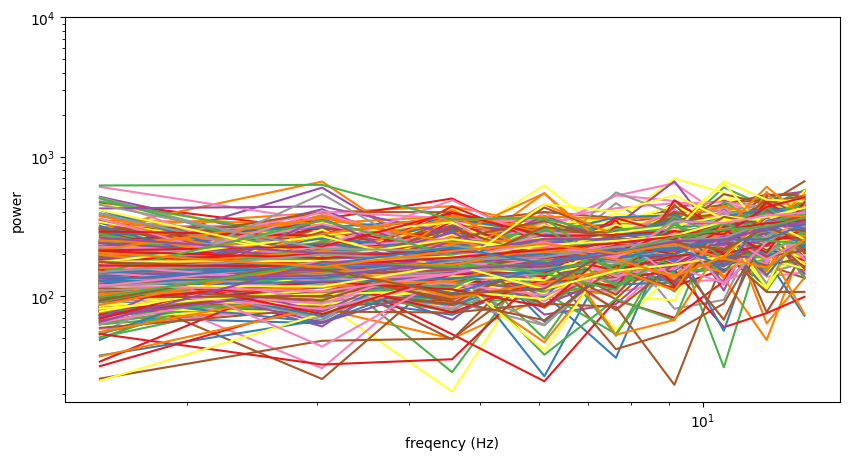

In [8]:
# test の可視化

fig,ax = plt.subplots(1,1,figsize=(10,5))

for d in df_test.iloc[:977,:].values.tolist():
    ax.plot(x,d)


ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylim(0,10**4)

ax.set_xlabel("freqency (Hz)")
ax.set_ylabel("power")

/usr/local/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == "":


Text(0, 0.5, 'power')

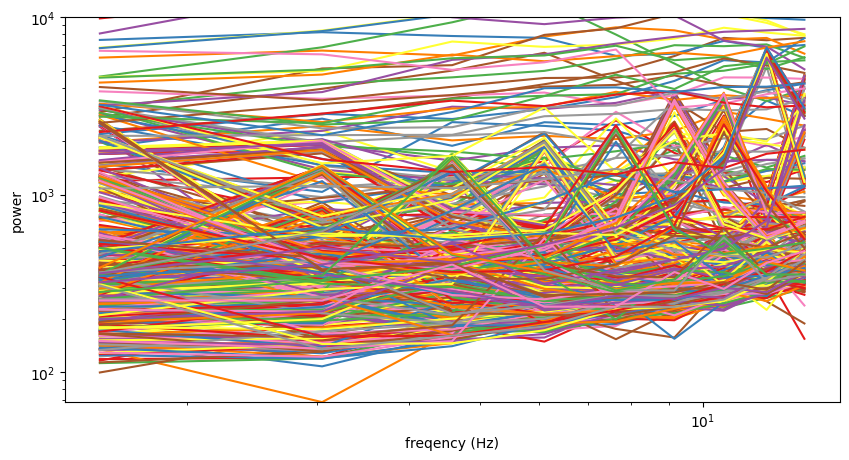

In [9]:
# test の可視化

fig,ax = plt.subplots(1,1,figsize=(10,5))

for d in df_test.iloc[977:,:].values.tolist():
    ax.plot(x,d)

ax.set_ylim(0,4000)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylim(0,10**4)

ax.set_xlabel("freqency (Hz)")
ax.set_ylabel("power")

## 正規化

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_approximation import RBFSampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from save_model import save_models as mysm

from sklearn.preprocessing import MinMaxScaler

In [11]:
#x_train,x_grid,y_train,y_grid = train_test_split(df_train.values.tolist(),y_train_true,random_state=0,test_size=0.5)
#x_per,x_test,y_per,y_test = train_test_split(df_test.values.tolist(),y_test_true,random_state=0,test_size=0.5)

In [12]:
df_train_log = np.log(df_train)
df_test_log = np.log(df_test)

In [13]:
ms = MinMaxScaler()
x_train_sc = ms.fit_transform(df_train_log)

ms = MinMaxScaler()
x_test_sc = ms.fit_transform(df_test_log)

## PCA再構成誤差法

In [14]:
import functools
from sklearn.decomposition import PCA

def J_PCA(k,List_train_std,List_test_std):
    pca = PCA(n_components=k,random_state=0)
    pca.fit(List_train_std)

    W = pca.components_
    mu = np.array(List_test_std).mean(axis=0)

    y_expect = np.array(list(map(functools.partial(y_recon_func,W=W,mu=mu),List_test_std)))
    gosa = y_expect-List_test_std
    J_pca = np.sum(gosa**2,axis=1)
    
    return J_pca

def y_recon_func(x,W,mu):
    return np.dot(W.T,np.dot(W,x-mu))+mu

In [15]:
k = 1

In [16]:
J_PCA_List = pd.DataFrame(J_PCA(k,x_train_sc,x_test_sc))

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.0e+00, 1.0e-06, 2.0e-06, 3.0e-06, 4.0e-06, 5.0e-06, 6.0e-06,
        7.0e-06, 8.0e-06, 9.0e-06, 1.0e-05, 1.1e-05, 1.2e-05, 1.3e-05,
        1.4e-05, 1.5e-05, 1.6e-05, 1.7e-05, 1.8e-05, 1.9e-05, 2.0e-05,
        2.1e-05, 2.2e-05, 2.3e-05, 2.4e-05, 2.5e-05, 2.6e-05, 2.7e-05,
        2.8e-05, 2.9e-05, 3.0e-05, 3.1e-05, 3.2e-05, 3.3e-05, 3.4e-05,
        3.5e-05, 3.6e-05, 3.7e-05, 3.8e-05, 3.9e-05, 4.0e-05, 4.1e-05,
        4.2e-05, 4.3e-05, 4.4e-05, 4.5e-05, 4.6e-05, 4.7e-05, 4.8e-05,
        4.9e-05, 5.0e-05, 5.1e-05, 5.2e-05, 5.3e-05, 

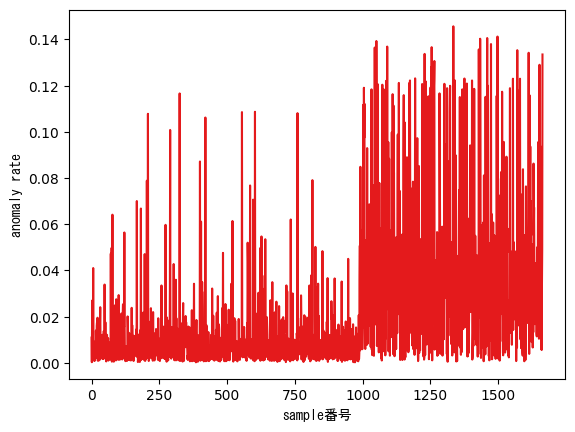

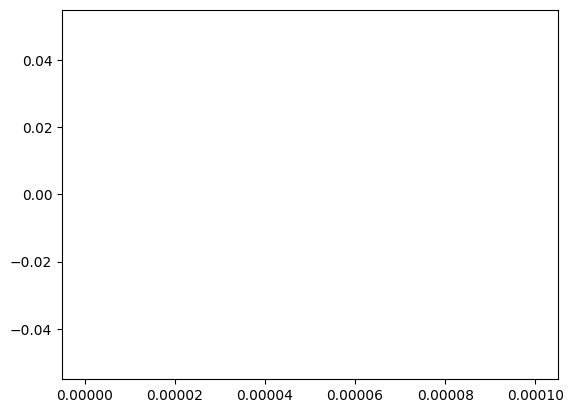

In [43]:
fig,ax = plt.subplots()

lim = len(J_PCA_List)

ax.plot(range(len(J_PCA_List)),J_PCA_List)
ax.set_xlabel("sample番号",fontname="MS Gothic")
ax.set_ylabel("anomaly rate",fontname="MS Gothic")

fig,ax = plt.subplots()

lim = len(J_PCA_List)

ax.hist(J_PCA_List,bins=100,range=[0,0.0001])



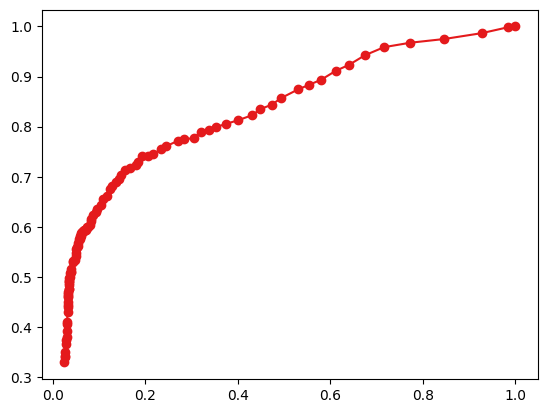

In [18]:
import copy
from sklearn.metrics import confusion_matrix

List_PCA_result = []

for lim in np.linspace(0,0.05,100):
    y_PCA_pred = np.ones(len(df_test))
    y_PCA_pred[J_PCA_List[(J_PCA_List>lim)[0]].index]=-2
    m = confusion_matrix(y_test_true,y_PCA_pred)
    
    FP = m[1][0]/sum(m[1])
    TP = m[0][0]/sum(m[0])
    
    List_PCA_result.append([FP,TP])

List_PCA_result = np.array(List_PCA_result)
fig,ax = plt.subplots()
ax.plot(List_PCA_result.T[0],List_PCA_result.T[1])
ax.scatter(List_PCA_result.T[0],List_PCA_result.T[1])
#ax.plot([0,1],[0,1])

## Kmeans 再構成誤差法

In [34]:
len(x_test_sc)

1665

In [35]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
def J_Kmeans(k,X_train,X_test):
    np_test = np.array(X_test)
    miniKM = MiniBatchKMeans(n_clusters=k,random_state=0)
    miniKM.fit(X_train)
    centers = miniKM.cluster_centers_
    clusters = miniKM.predict(X_test)
    cluster_centers = np.array([centers[i] for i in clusters])
    gosa_vectors =  cluster_centers-np_test
    gosas = np.sqrt(np.sum(gosa_vectors**2,axis=1))
    return gosas

In [36]:
k=1

In [37]:
J_KMeans_List=J_Kmeans(k,x_train_sc,x_test_sc)
J_KMeans_List = pd.DataFrame(J_KMeans_List)
J_KMeans_List.index = df_test.index

(array([  0.,   0.,   0.,   0.,   0.,   1.,   3.,   6.,  39., 293., 439.,
        211., 115., 100.,  48.,  45.,  70.,  31.,  19.,  37.,  51.,  36.,
         40.,  19.,  12.,   8.,   4.,   2.,   3.,   1.,   2.,   3.,   3.,
          4.,   2.,   2.,   2.,   3.,   3.,   2.,   1.,   1.,   0.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.

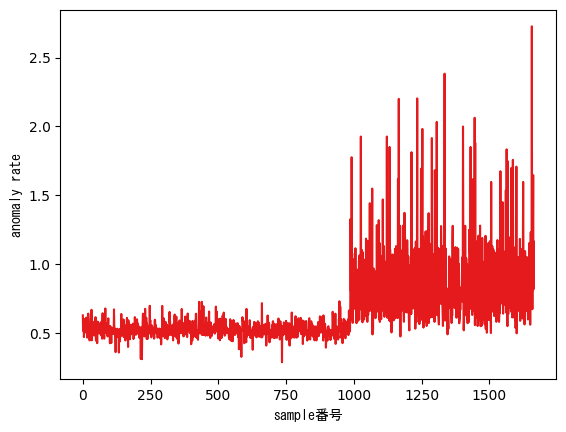

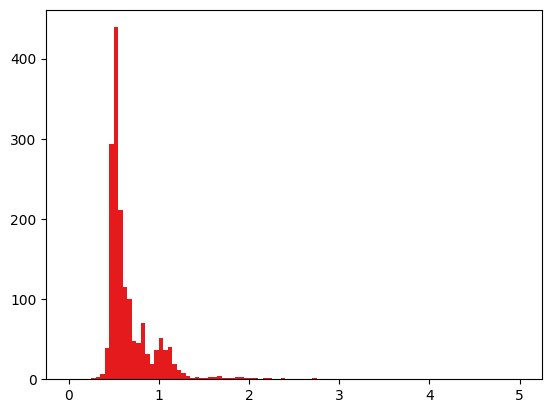

In [22]:
fig,ax = plt.subplots()

ax.plot(range(len(J_KMeans_List)),J_KMeans_List)


ax.set_xlabel("sample番号",fontname="MS Gothic")
ax.set_ylabel("anomaly rate",fontname="MS Gothic")

fig,ax = plt.subplots()

ax.hist(J_KMeans_List,bins=100,range=[0,5])


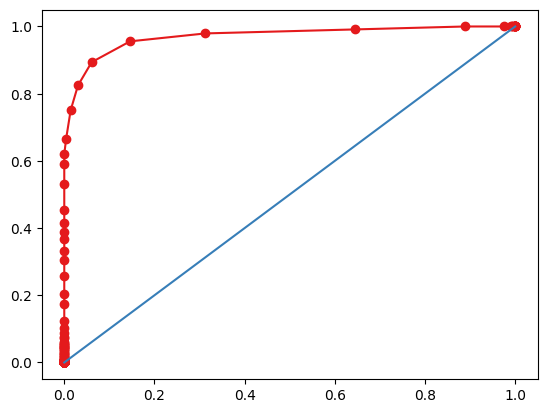

In [23]:
import copy
from sklearn.metrics import confusion_matrix

List_Kmeans_result = []

for lim in np.linspace(0,10,300):
    
    y_Kmeans_pred = np.ones(len(df_test))
    y_Kmeans_pred[J_KMeans_List[(J_KMeans_List>lim)[0]].index]=-2
    m = confusion_matrix(y_test_true,y_Kmeans_pred)
    
    FP = m[1][0]/sum(m[1])
    TP = m[0][0]/sum(m[0])
    
    List_Kmeans_result.append([FP,TP])

List_Kmeans_result = np.array(List_Kmeans_result)
fig,ax = plt.subplots()

ax.plot(List_Kmeans_result.T[0],List_Kmeans_result.T[1])
ax.plot([0,1],[0,1])
ax.scatter(List_Kmeans_result.T[0],List_Kmeans_result.T[1])

## 結果比較

In [33]:
len(J_PCA_List)

1665

0.9717223611970364
0.8296557309925789


Text(0, 0.5, '陽性率')

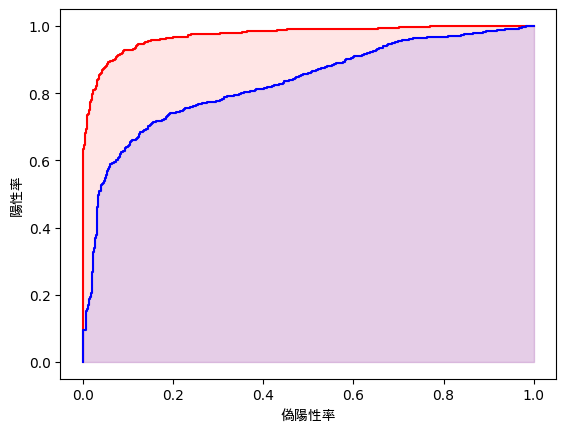

In [44]:
y_test_true_ = [1 if i == -2 else -1 for i in y_test_true]

fpr_kmeans, tpr_kmeans, thresholds_kmeans = roc_curve(y_test_true_, J_KMeans_List)
fpr_PCA, tpr_PCA, thresholds_PCA = roc_curve(y_test_true_, J_PCA_List)

print(roc_auc_score(y_test_true_, J_KMeans_List))
print(roc_auc_score(y_test_true_, J_PCA_List))

plt.plot(fpr_kmeans, tpr_kmeans, color="red", label='logistic')
plt.fill_between(fpr_kmeans, tpr_kmeans, 0, color="red", alpha=0.1)

plt.plot(fpr_PCA, tpr_PCA, color="blue", label='logistic')
plt.fill_between(fpr_PCA, tpr_PCA, 0, color="blue", alpha=0.1)


plt.xlabel("偽陽性率",fontname="MS Gothic")
plt.ylabel("陽性率",fontname="MS Gothic")

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

x_ktest,x_test_,y_ktest,y_test_ = train_test_split(df_test.values.tolist(),y_test_true)
ms = MinMaxScaler()
x_ktest_sc = ms.fit_transform(x_ktest)

for k in range(1,5):
    J_KMeans_List=J_Kmeans(k,x_train_sc,x_ktest_sc)
    J_KMeans_List = pd.DataFrame(J_KMeans_List)
    J_KMeans_List.index = range(len(x_ktest_))
    
    y_test_ = [1 if i == -2 else -1 for i in y_test_]
   
    print(roc_auc_score(y_ktest, J_KMeans_List))
    

NameError: name 'x_ktest_' is not defined

In [115]:
from sklearn.svm import LinearSVC

In [118]:
svc = LinearSVC(random_state=0)
svc.fit(x_train_sc,y_train_true)
svc_predict = svc.predict(x_test_sc)

In [120]:
confusion_matrix(y_test_true,svc_predict)

array([[678,   0],
       [986,   1]])

In [121]:
len(x_train_sc)

3224

In [122]:
len(y_train_true)

3224

In [123]:
len(x_test_sc)

1665

In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_approximation import RBFSampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler

In [34]:
def Ksaikousei_class_per(k,per,is_k = False,is_per = False,PLOT=False):
#train test split
    df_train,df_test = myds.train_test_dataframe(df_data=df_data7_pre,test_frac=0.01)
    #教師 normal　加工①　ピーク1500以下 
    df_train = df_train[(df_train.iloc[:,:9]<1500).all(axis=1)]
    ######################################
    
    #テスト noraml 加工
    df_test_ = df_test[~df_test.index.isin(List_test_Lowindex )]
    
    ###################################3

    #教師 normal 加工②　avarage 化

    lim = len(df_train)//per*per

    df_train = df_train.sample(frac=1)
    df_train = df_train.to_numpy()[:lim].reshape([int(lim/per),per,len(df_train.to_numpy()[0])])
    df_train = pd.DataFrame(myvs.avarange(df_train))
    df_train.columns = df_data7_pre.columns
    ####################################
    
    #テスト正解作成
    y_test_true = np.concatenate([
    np.ones(len(df_test_)),
    np.ones(len(df_ImamuraAbnormal_test))*-2,])

    #テストデータ
    df_test = pd.concat([df_test_,df_ImamuraAbnormal_test])
    df_test.index = range(len(df_test))
    
    
    ############################################
    
    #4分割
   
    x_train = df_train.values.tolist()
    
    x_per,x_test,y_per,y_test = train_test_split(df_test.values.tolist(),y_test_true,random_state=0,test_size=0.5)

    ###############################################

    #正規化
    x_train = np.log(x_train)
    x_per = np.log(x_per)
    x_test = np.log(x_test)

    mn = MinMaxScaler()
    mn.fit(x_train)
    x_train_std = mn.transform(x_train)

    mn = MinMaxScaler()
    mn.fit(x_per)
    x_per_std = mn.transform(x_per)

    mn = MinMaxScaler()
    mn.fit(x_test)
    x_test_std = mn.transform(x_test)
    
    #################################################

    #学習
    if is_k:
        target = x_train
        target_std = x_train_std
        target_y = None
    
    
    elif is_per:
        target = x_per
        target_std = x_per_std
        target_y = y_per
    else:
        target = x_test
        target_std = x_test_std
        target_y = y_test

    J_KMeans_List=J_Kmeans(k,x_train_std,target_std)
    J_KMeans_List = pd.DataFrame(J_KMeans_List)
    J_KMeans_List.index = range(len(J_KMeans_List))

    #plot
    if PLOT:

        fig,ax = plt.subplots()
        ax.plot(range(len(J_KMeans_List)),J_KMeans_List)
        fig,ax = plt.subplots()
        ax.hist(J_KMeans_List,bins=100,range=[0,60000])
        
    return [J_KMeans_List,target,target_y]


In [35]:
import numpy as np
def J_Kmeans(k,X_train,X_test):
    np_test = np.array(X_test)
    miniKM = MiniBatchKMeans(n_clusters=k,random_state=0)
    miniKM.fit(X_train)
    centers = miniKM.cluster_centers_
    clusters = miniKM.predict(X_test)
    cluster_centers = np.array([centers[i] for i in clusters])
    gosa_vectors =  cluster_centers-np_test
    gosas = np.sqrt(np.sum(gosa_vectors**2,axis=1))
    return gosas

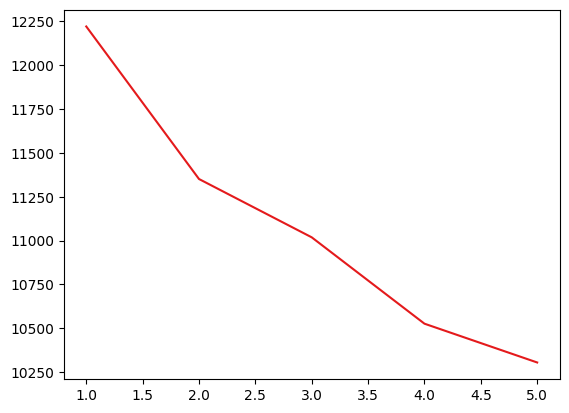

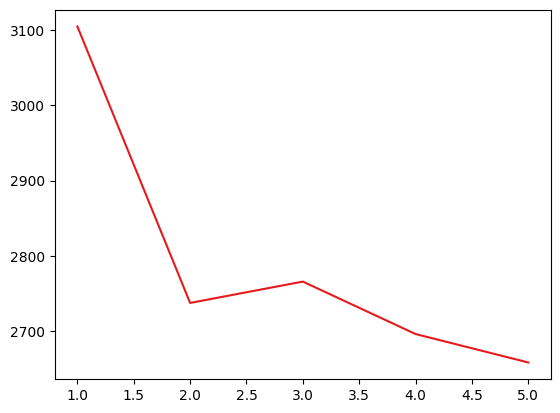

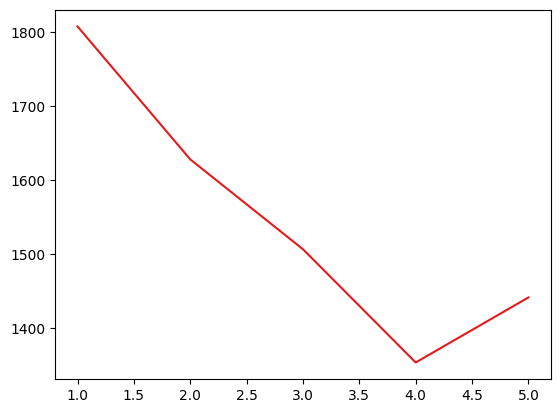

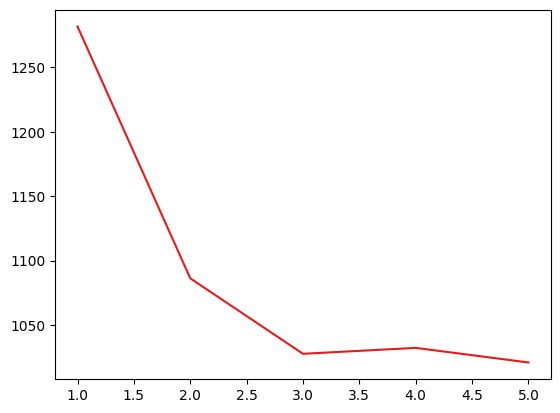

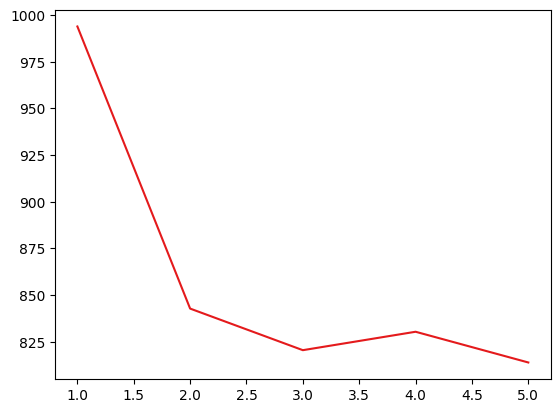

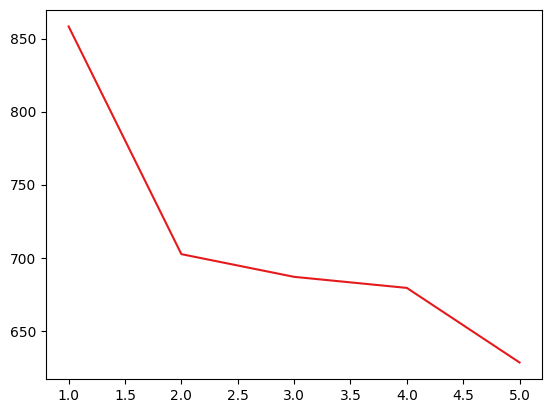

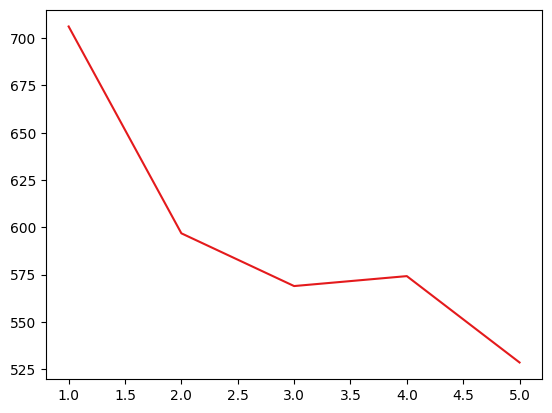

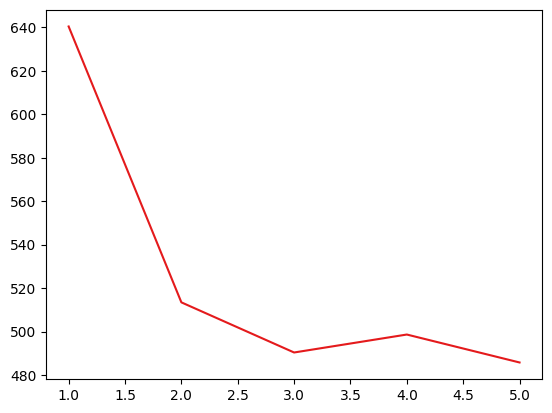

In [36]:
for per in [1]+list(range(10,80,10)):
    fig,ax = plt.subplots()
    gosa = []
    for k in range(1,6):
        gosas = Ksaikousei_class_per(k,per,is_k=True)[0]
        gosa.append(sum(gosas[0]))
    ax.plot(range(1,6),gosa)

0.9627787087464507
0.4260345389377647
0.4586242610436159
0.31525508541637576
0.862879951589629
0.5101126472094214
0.5399501931759996


/usr/local/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == "__main__":


0.5382977237815948


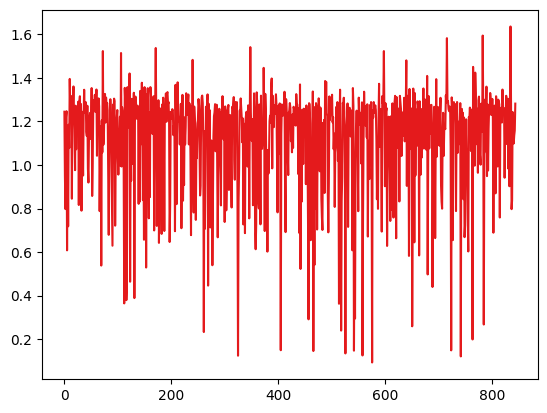

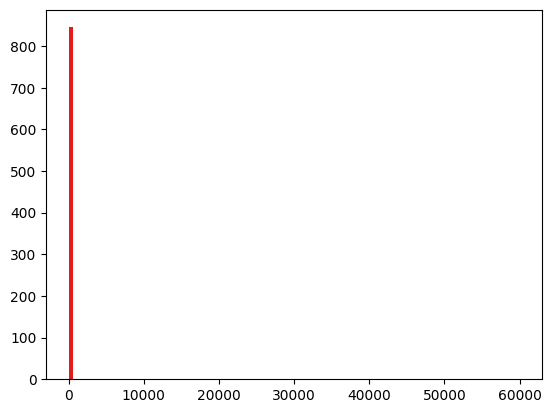

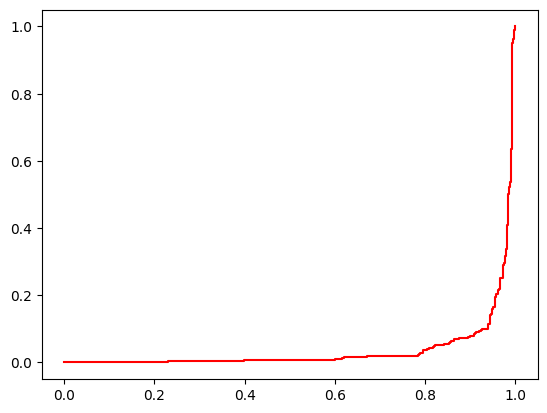

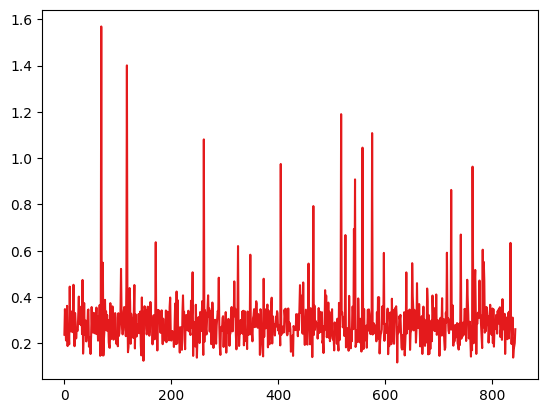

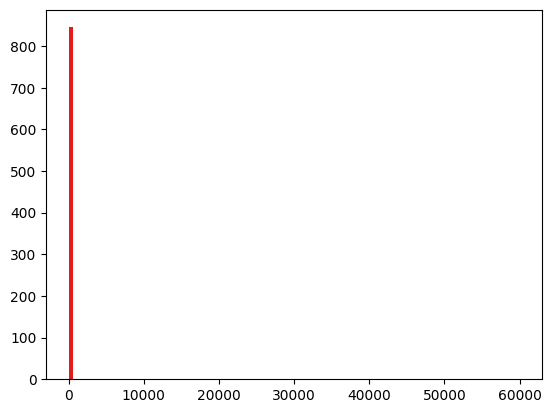

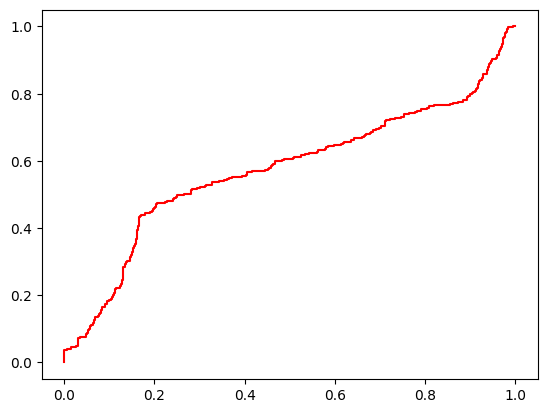

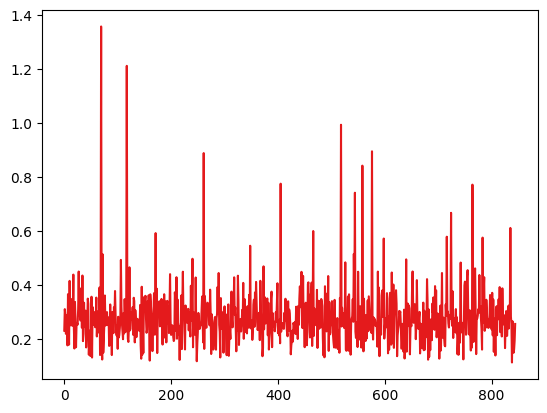

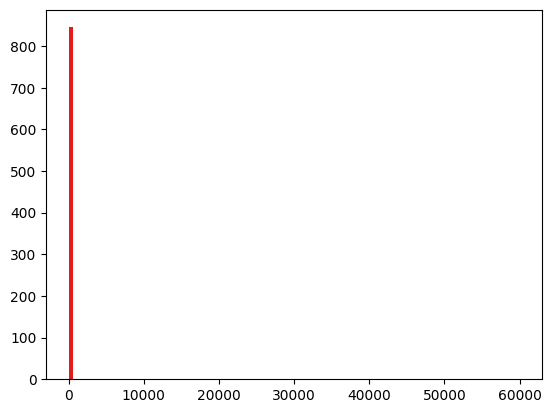

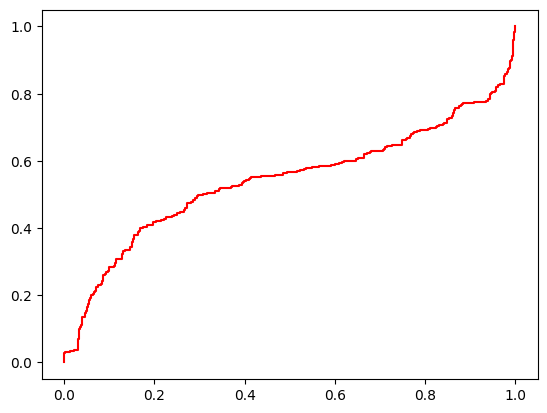

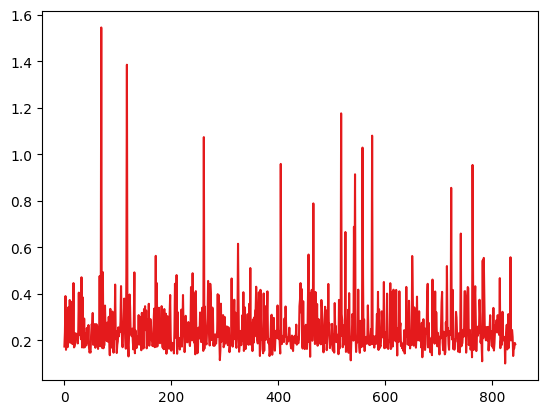

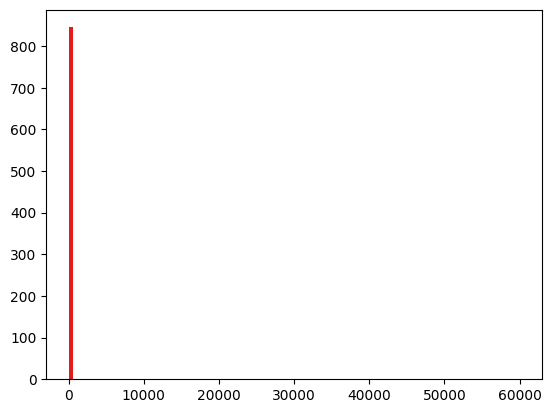

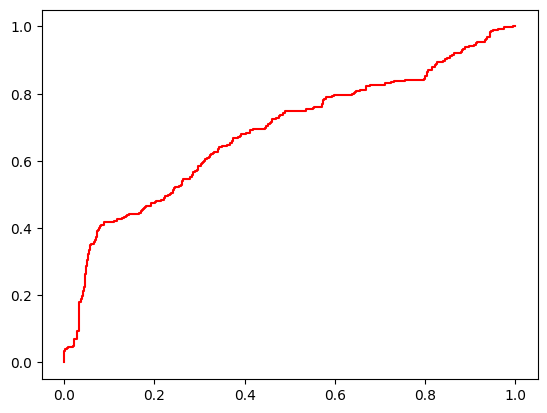

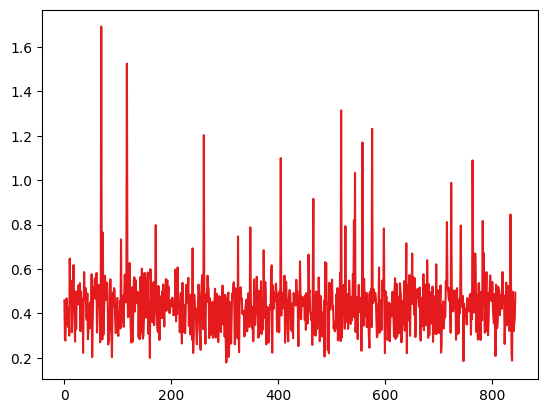

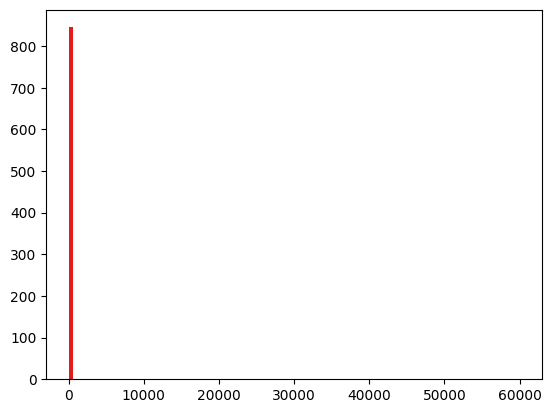

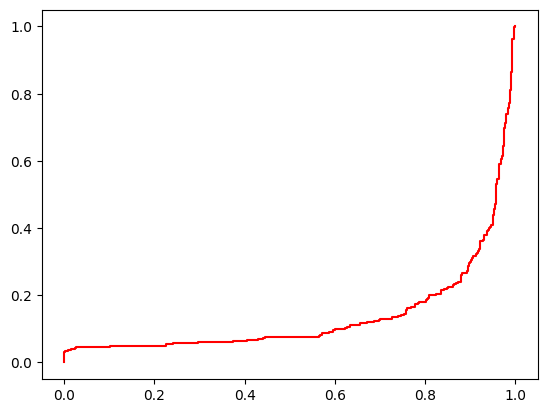

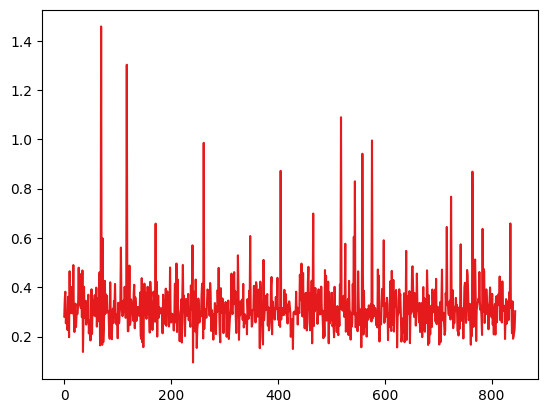

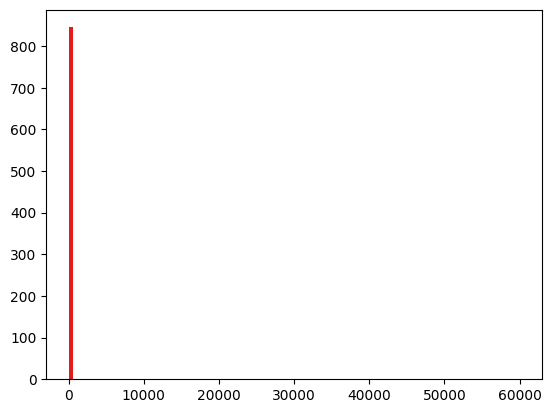

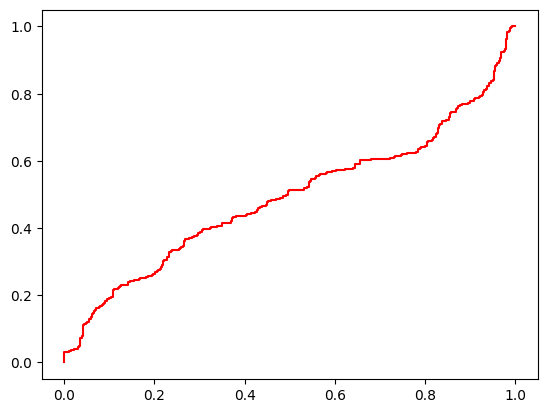

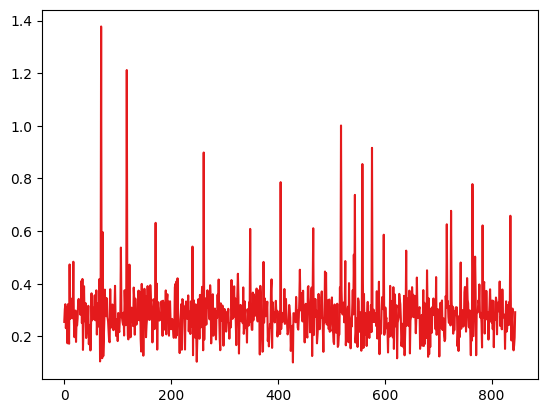

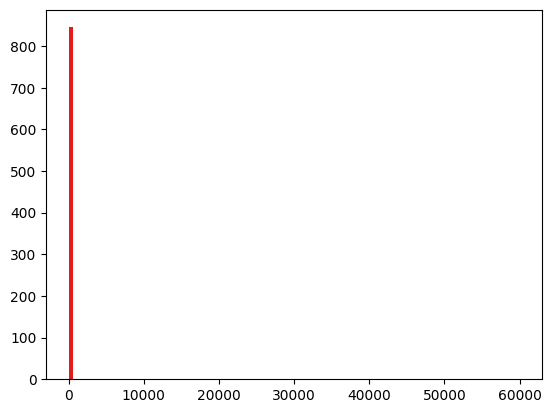

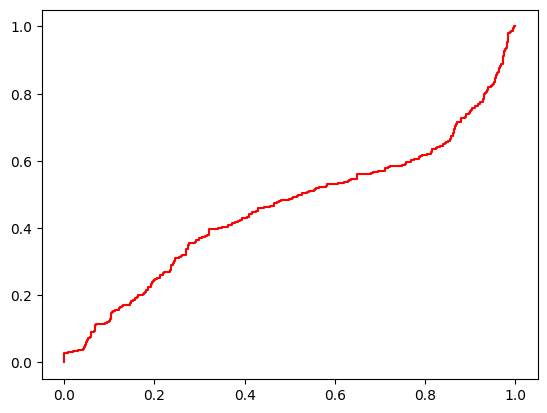

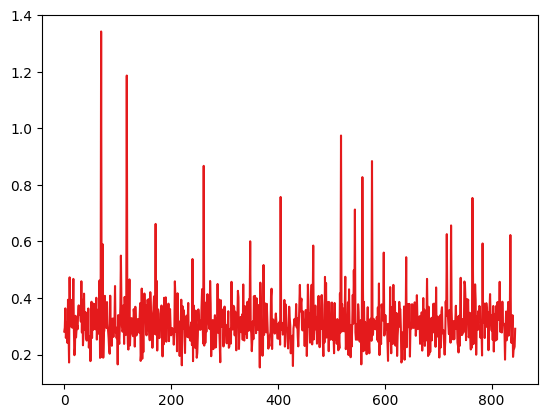

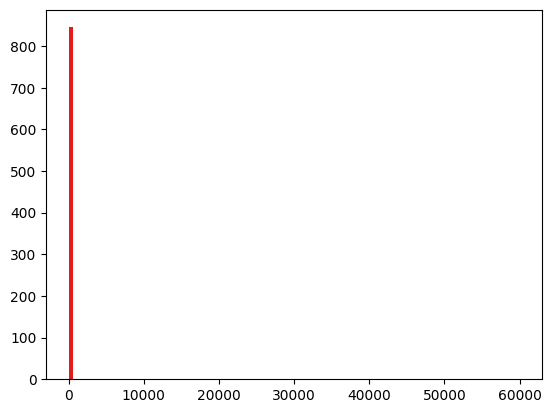

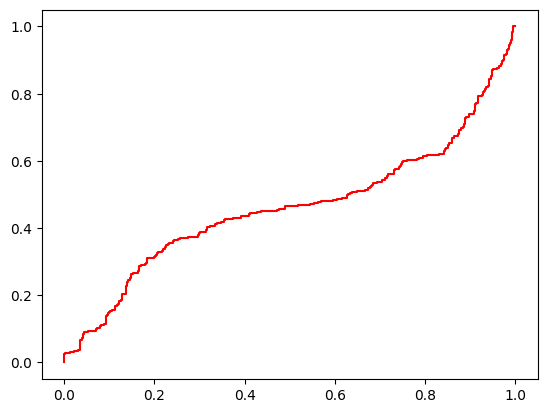

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

for per,k in zip([1]+list(range(10,80,10)),[4,2,4,3,1,2,3,3]):
    J_KMeans_List,x_per,y_per = Ksaikousei_class_per(k,per,is_per=True,PLOT=True)
    
    y_per_true = [-1 if i == 1 else 1 for i in y_per]
    print(roc_auc_score(y_per, J_KMeans_List[0]))
    fpr_kmeans, tpr_kmeans, thresholds_kmeans = roc_curve(y_per_true, J_KMeans_List)
    fig,ax = plt.subplots()
    ax.plot(fpr_kmeans, tpr_kmeans, color="red", label='logistic')

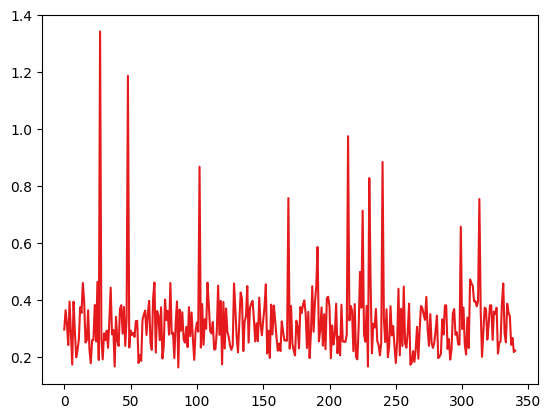

In [54]:
fig,ax = plt.subplots()

d = J_KMeans_List[0][y_per == -2]
ax.plot(range(len(d)),d)

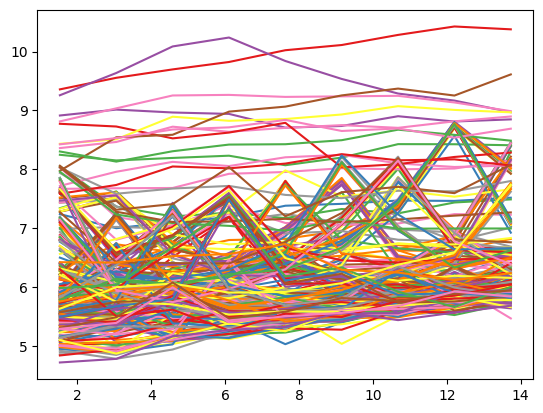

In [56]:
fid,ax = plt.subplots()
for d in x_per[y_per==-2]:
    ax.plot(x,d)

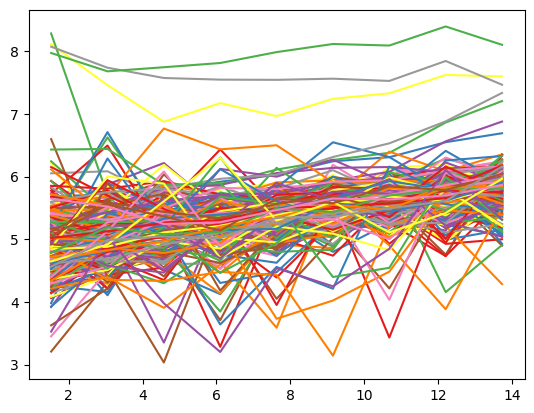

In [57]:
fid,ax = plt.subplots()
for d in x_per[y_per==1]:
    ax.plot(x,d)

In [45]:
J_KMeans_List

0
0    0.281100
1    0.294954
2    0.363140
3    0.258805
4    0.288701
..        ...
840  0.191657
841  0.216098
842  0.220992
843  0.227978
844  0.291076

[845 rows x 1 columns]